In [196]:
# leer df_sin_anomalos.csv
import pandas as pd
df_final = pd.read_csv("df_final.csv")

In [110]:
same = df_final[["SAME-TT2R2_MAS3","TRT"]]

In [197]:
indice_test = pd.read_csv("indices_test.csv")
indice_train = pd.read_csv("indices_train.csv")

df_test = df_final.iloc[indice_test["0"],:]
df_train = df_final.iloc[indice_train["0"],:]

In [112]:
SAME_test = same.iloc[indice_test["0"],:]
SAME_train = same.iloc[indice_train["0"],:]

In [113]:
SAME_X_test= SAME_test.drop(columns=["TRT"])
SAME_y_test = pd.DataFrame(SAME_test["TRT"])

SAME_X_train = SAME_train.drop(columns=["TRT"])
SAME_y_train = pd.DataFrame(SAME_train["TRT"])

In [198]:
X_test_todos = df_test.drop(columns=["TRT"])
y_test = pd.DataFrame(df_test["TRT"])

X_train_todos = df_train.drop(columns=["TRT"])
y_train = pd.DataFrame(df_train["TRT"])

In [199]:
X_test_final = X_test_todos[["ARTERIOPATIA_PERIFERICA","ENFERMEDAD_VASCULAR","SAME_MAS_DE_2","N_PASTILLAS_D_INICIO","NEOPLASIA_NO","ADE","MONOCITOS","DISLIPEMIA","AMIODARONA","EDAD","INSUFICIENCIA_CARDIACA","SAME-TT2R2_MAS3","NEUTROFILOS"]]
X_train_final = X_train_todos[["ARTERIOPATIA_PERIFERICA","ENFERMEDAD_VASCULAR","SAME_MAS_DE_2","N_PASTILLAS_D_INICIO","NEOPLASIA_NO","ADE","MONOCITOS","DISLIPEMIA","AMIODARONA","EDAD","INSUFICIENCIA_CARDIACA","SAME-TT2R2_MAS3","NEUTROFILOS"]]

In [200]:
# hacer una funcion que entrene modelos de regresion mediante gridsearch y los valide con el dataset de validacion y cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from scipy.stats import f_oneway
from lifelines.utils import concordance_index
import statsmodels.api as sm
import time
# sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
# linear regression
from sklearn.linear_model import LinearRegression

# no mostrar warnings
import warnings

# r2 ajustado
def r2_adj(r2, n, p):
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return r2_adj

def train_model_gridsearch(model, X_train, X_val, y_train, y_val, params,DF):
    warnings.filterwarnings('ignore')
    grid = GridSearchCV(model, params, cv=5, scoring=["neg_root_mean_squared_error",'neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], refit='r2')
    grid.fit(X_train, y_train)
    print("Best params: ", grid.best_params_)
    print("Best score: ", grid.best_score_)
    start = time.time()
    y_pred = grid.predict(X_val)
    end = time.time()
    print("Time: ", end - start)
    print()
    print("MAE: ", mean_absolute_error(y_val, y_pred))
    # desviacion estandar de MAE
    print("MAE std: ", np.std(mean_absolute_error(y_val, y_pred)))
    print("MSE: ", mean_squared_error(y_val, y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred)))
    print("R2: ", r2_score(y_val, y_pred))
    print("R2 ajustado: ", r2_adj(r2_score(y_val, y_pred), len(y_val), len(X_val.columns)))
    print()

    # residuos
    residuos = y_val - y_pred

    # crear un dataframe donde se vayan almacenando los resultados de cada modelo
    DF = DF.append({"Modelo": str(model),"R2 ajustado":r2_adj(r2_score(y_val, y_pred), len(y_val), len(X_val.columns)),"R2 ajustado std": np.std(r2_adj(r2_score(y_val, y_pred), len(y_val), len(X_val.columns))),"MAE": mean_absolute_error(y_val, y_pred),"MAE_std":np.sqrt(mean_squared_error(y_val, y_pred)), "MSE": mean_squared_error(y_val, y_pred),"MSE std": np.std(mean_squared_error(y_val, y_pred)) , "RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),"RMSE std": np.std(np.sqrt(mean_squared_error(y_val, y_pred))), "R2": r2_score(y_val, y_pred),"R2 std": np.std(r2_score(y_val, y_pred)), "Time": end - start,"Residuos":residuos}, ignore_index=True)

    # grafico de real vs pred
    plt.scatter(y_val, y_pred)
    plt.title("Real vs Predicted")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    # same axis 0-100
    plt.plot([0, 100], [0, 100], 'k-', color = 'r')
    plt.show()

    # grafico de distribucion de residuos
    sns.distplot(y_val - y_pred)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

    return DF

In [201]:
SIGNIFICATIVAS = pd.DataFrame(columns=["Modelo","R2 ajustado","R2 ajustado std", "MAE", "MAE_std","MSE","MSE std", "RMSE","RMSE std", "R2","R2 std" "Time","Residuos"])
TODAS = pd.DataFrame(columns=["Modelo","R2 ajustado","R2 ajustado std", "MAE", "MAE_std","MSE","MSE std", "RMSE","RMSE std", "R2","R2 std" "Time","Residuos"])

In [116]:
SAME = pd.DataFrame(columns=["Modelo","R2 ajustado","R2 ajustado std", "MAE", "MAE_std","MSE","MSE std", "RMSE","RMSE std", "R2","R2 std" "Time","Residuos"])

Model:  LinearRegression()
Best params:  {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Best score:  -0.013052407439092195
Time:  0.0067980289459228516

MAE:  15.474420456065268
MAE std:  0.0
MSE:  362.65093217259755
MSE std:  0.0
RMSE:  19.043396025199854
RMSE std:  0.0
R2:  -0.0038108680602952916
R2 std:  0.0
C-index:  0.5278311965811966
R2 ajustado:  -0.0739696921720363
R2 ajustado std:  0.0

MAE train:  15.925012162633053
MSE train:  384.9394365664245
RMSE train:  19.61987351045935
R2 train:  -0.0018887241602967286
C-index train:  0.5454073088557491


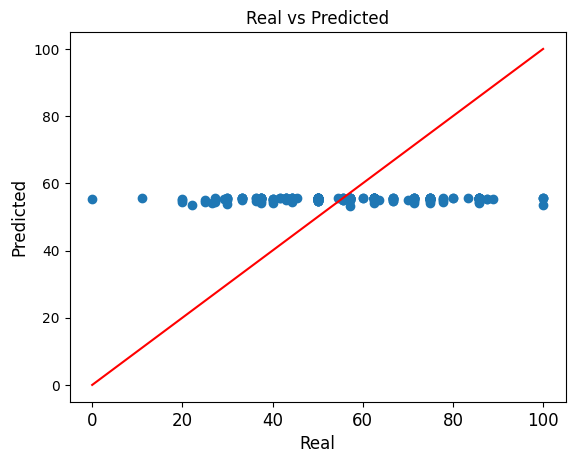

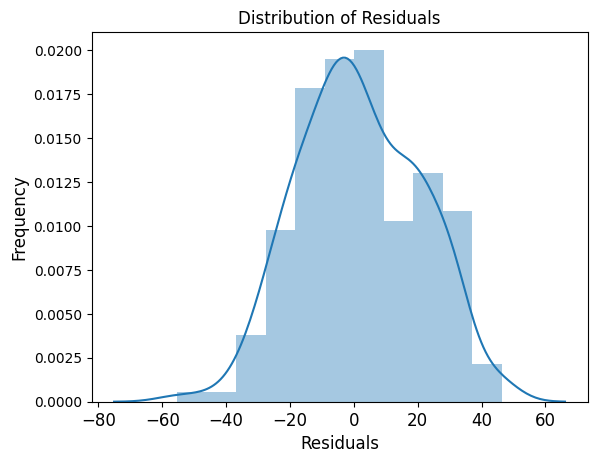


Model:  LinearRegression()
Best params:  {'criterion': 'friedman_mse', 'max_depth': 1, 'splitter': 'random'}
Best score:  -0.0030583860123935213
Time:  0.001725912094116211

MAE:  15.605804289226585
MAE std:  0.0
MSE:  361.87671149350047
MSE std:  0.0
RMSE:  19.023057364511637
RMSE std:  0.0
R2:  -0.0016678399773433217
R2 std:  0.0
C-index:  0.5076923076923077
R2 ajustado:  -0.07167688255640492
R2 ajustado std:  0.0

MAE train:  16.02694661423621
MSE train:  382.0810721888978
RMSE train:  19.54689418268022
R2 train:  0.005550791689078349
C-index train:  0.5233788068336014


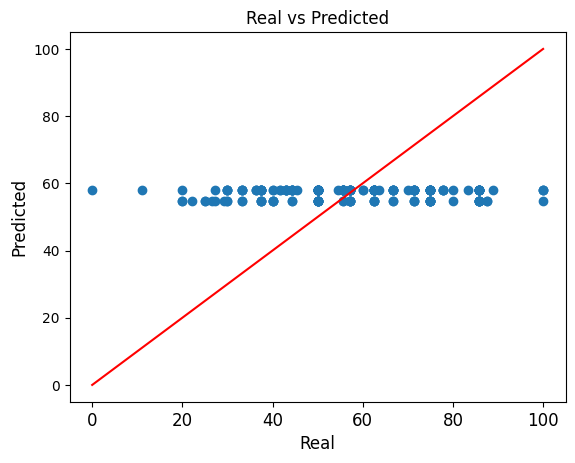

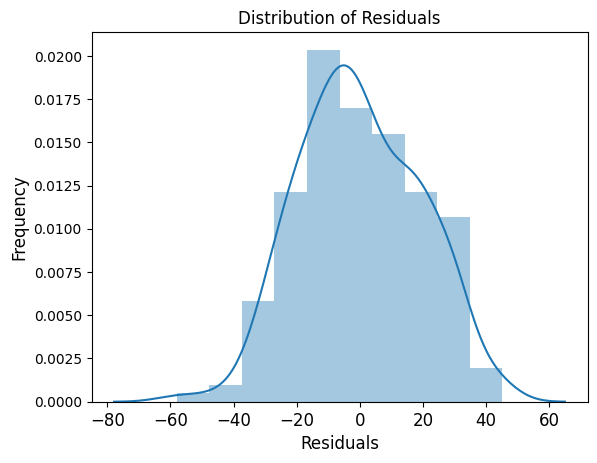


Model:  LinearRegression()
Best params:  {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
Best score:  -0.07068984363780159
Time:  0.0070798397064208984

MAE:  15.281050000000002
MAE std:  0.0
MSE:  350.01137350000005
MSE std:  0.0
RMSE:  18.70859090097381
RMSE std:  0.0
R2:  0.031175189433141903
R2 std:  0.0
C-index:  0.5666399572649573
R2 ajustado:  -0.036538372595724455
R2 ajustado std:  0.0

MAE train:  14.829337500000001
MSE train:  336.2910046250001
RMSE train:  18.338238863778606
R2 train:  0.12472941568254625
C-index train:  0.6282971597264971


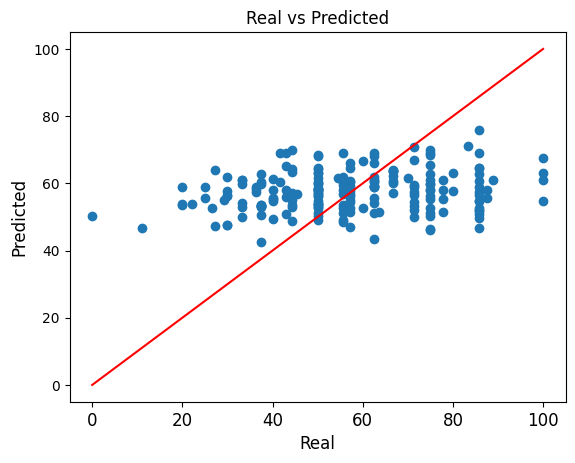

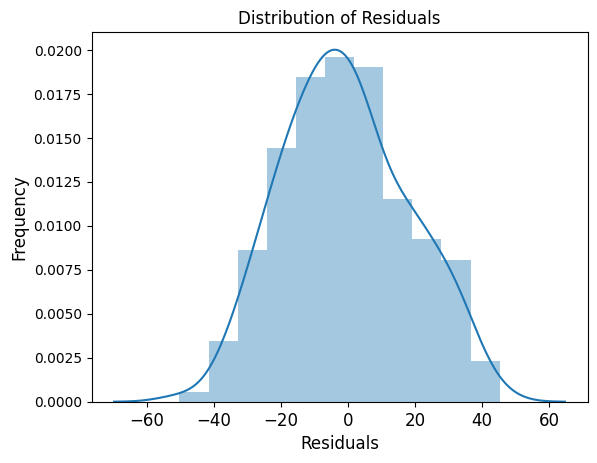


Model:  LinearRegression()
Best params:  {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
Best score:  -0.0032719393383963792
Time:  0.0022139549255371094

MAE:  15.49806608668488
MAE std:  0.0
MSE:  361.28107992627525
MSE std:  0.0
RMSE:  19.007395400903178
RMSE std:  0.0
R2:  -1.9143152111045225e-05
R2 std:  0.0
C-index:  0.5132478632478632
R2 ajustado:  -0.06991295423263488
R2 ajustado std:  0.0

MAE train:  16.070125257522715
MSE train:  384.21845941754987
RMSE train:  19.601491254941546
R2 train:  -1.2224100241153835e-05
C-index train:  0.4866227155688821


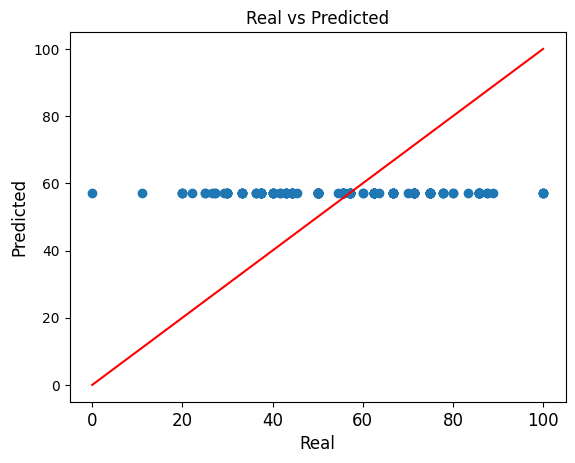

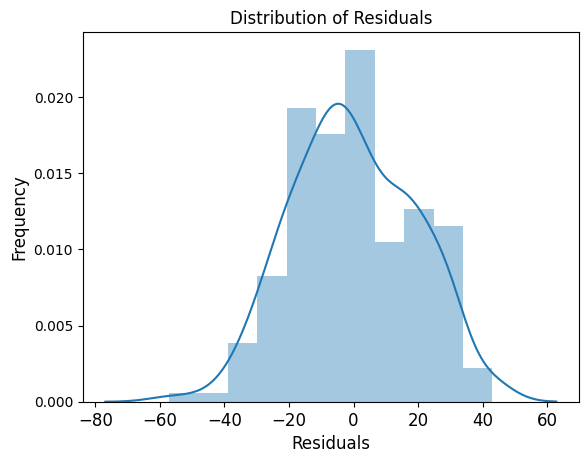


Model:  LinearRegression()
Best params:  {}
Best score:  -0.014135989607400945
Time:  0.001402139663696289

MAE:  15.10782386308001
MAE std:  0.0
MSE:  343.6728388655317
MSE std:  0.0
RMSE:  18.538415219903012
RMSE std:  0.0
R2:  0.048720132487714674
R2 std:  0.0
C-index:  0.5727029914529914
R2 ajustado:  -0.017767170080348338
R2 ajustado std:  0.0

MAE train:  15.710700848091893
MSE train:  371.99732487456475
RMSE train:  19.28723217246489
R2 train:  0.031795940332788875
C-index train:  0.5607041442443257


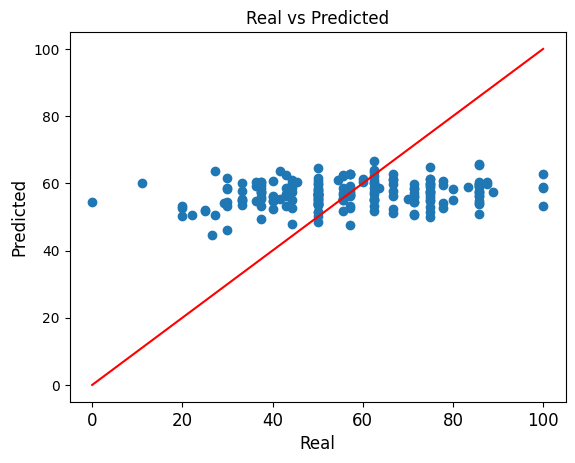

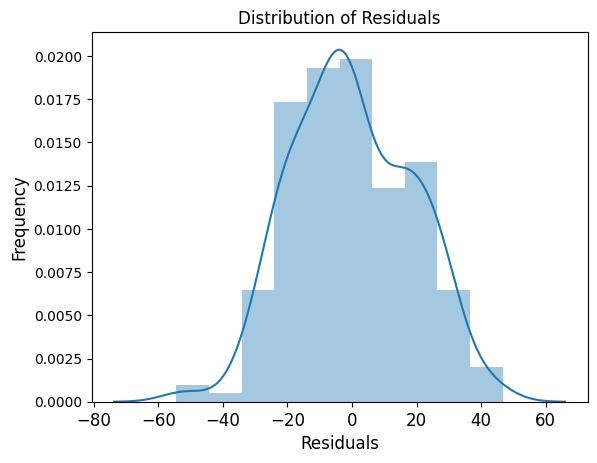


Model:  LinearRegression()
Best params:  {'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 250}
Best score:  0.0026695885052314904
Time:  0.040319204330444336

MAE:  15.38107111508243
MAE std:  0.0
MSE:  351.7591786248424
MSE std:  0.0
RMSE:  18.75524402999978
RMSE std:  0.0
R2:  0.026337298161065337
R2 std:  0.0
C-index:  0.5580662393162393
R2 ajustado:  -0.041714396053483815
R2 ajustado std:  0.0

MAE train:  15.57730297491613
MSE train:  360.08314259110006
RMSE train:  18.97585683417484
R2 train:  0.06280519465566692
C-index train:  0.6150158528432521


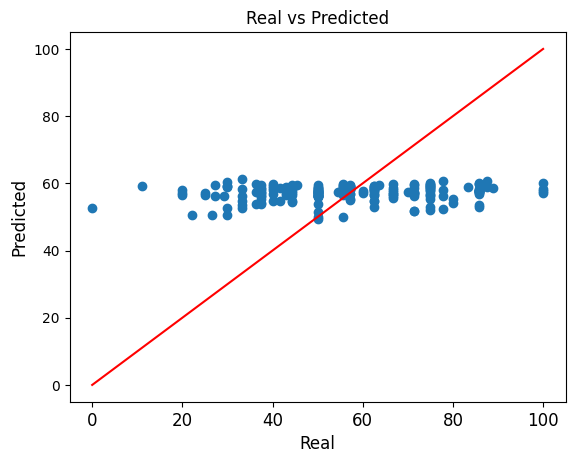

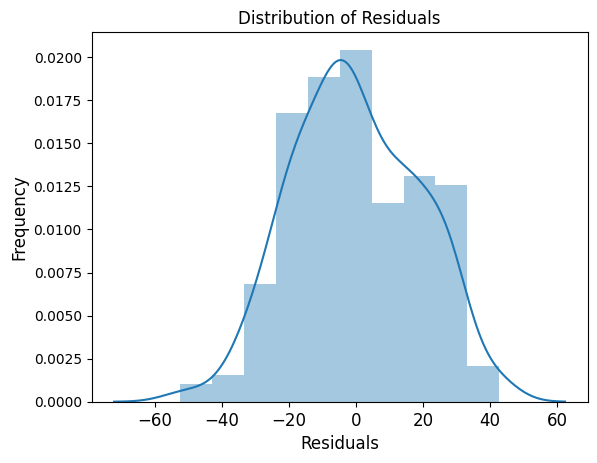

In [202]:
# lista con los modelos a probar (linear regression, svr, neural network, decisiom tree and regresion polinomica) y sus parametros
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# voting regressor
from sklearn.ensemble import VotingRegressor
# sequential
# ada boost regressor
from sklearn.ensemble import AdaBoostRegressor


models = [SVR(), DecisionTreeRegressor(), KNeighborsRegressor(),MLPRegressor(),LinearRegression(),AdaBoostRegressor()]
params = [{"kernel": ["linear", "poly", "rbf", "sigmoid"], "C": [0.1, 1, 10, 100, 1000], "gamma": ["scale", "auto"]},
            {"criterion": ["mse", "friedman_mse", "mae"], "splitter": ["best", "random"], "max_depth": [None, 1,2, 3,4, 5,6, 7, 8, 9,10]},
            {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]},
            {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)], "activation": ["tanh", "relu"], "solver": ["sgd", "adam"], "learning_rate": ["constant", "invscaling", "adaptive"]},
            {},
            {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], "learning_rate": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "loss": ["linear", "square", "exponential"]}]

# entrenar los modelos con el dataset de entrenamiento y validarlos con el dataset de validacion
for i in range(len(models)):
    print("Model: ", models[i])
    TODAS = train_model_gridsearch(models[i], X_train_todos, X_test_todos, y_train["TRT"], y_test["TRT"], params[i],TODAS)
    SIGNIFICATIVAS = train_model_gridsearch(models[i], X_train_final, X_test_final, y_train["TRT"], y_test["TRT"], params[i],SIGNIFICATIVAS)
    SAME = train_model_gridsearch(models[i], SAME_X_train, SAME_X_test, SAME_y_train["TRT"], SAME_y_test["TRT"], params[i],SAME)
    print("")

Model:  VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('knn', KNeighborsRegressor(n_neighbors=10)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.01,
                                               n_estimators=150))])
Best params:  {'weights': [2, 1, 2]}
Best score:  -7.757357322233372e-05
Time:  0.021789073944091797

MAE:  15.08443671348831
MAE std:  0.0
MSE:  340.4701702402919
MSE std:  0.0
RMSE:  18.45183379071825
RMSE std:  0.0
R2:  0.05758505819892534
R2 std:  0.0
C-index:  0.5886752136752137
R2 ajustado:  -0.00828265278717133
R2 ajustado std:  0.0

MAE train:  15.373763987648017
MSE train:  353.13033363543667
RMSE train:  18.791762387690962
R2 train:  0.08090139429697807
C-index train:  0.6249098142007056


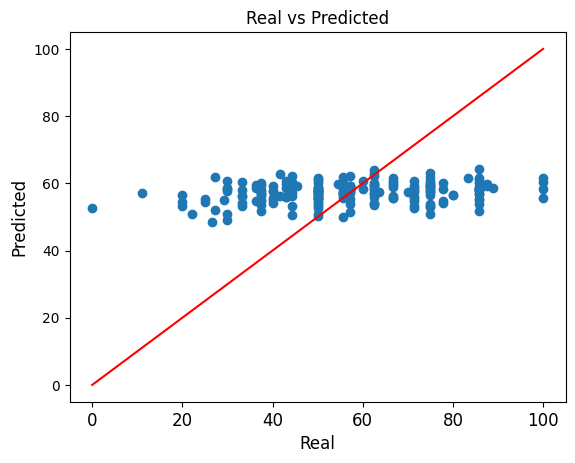

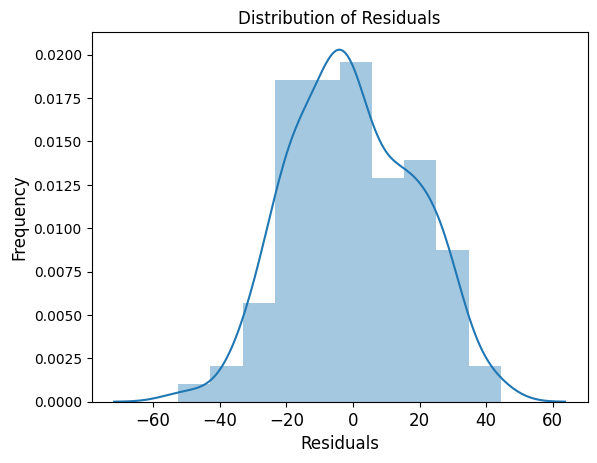

In [203]:
# VOTING de linear regression, knn y mlp
models = [("lr", LinearRegression()), ("knn", KNeighborsRegressor(n_neighbors=10)), ("ada", AdaBoostRegressor(learning_rate=0.01,n_estimators=150))]
voting = VotingRegressor(estimators=models)
params = {"weights": [[1,1,1], [1,2,1], [1,1,2], [1,2,2], [2,1,1], [2,2,1], [2,1,2], [2,2,2]]}
print("Model: ", voting)
TODAS = train_model_gridsearch(voting, X_train_todos, X_test_todos, y_train["TRT"], y_test["TRT"], params,TODAS)
SIGNIFICATIVAS = train_model_gridsearch(voting, X_train_final, X_test_final, y_train["TRT"], y_test["TRT"], params,SIGNIFICATIVAS)
SAME = train_model_gridsearch(voting, SAME_X_train, SAME_X_test, SAME_y_train["TRT"], SAME_y_test["TRT"], params,SAME)
print("")

In [204]:
SIGNIFICATIVAS

,Modelo,R2 ajustado,R2 ajustado std,MAE,MAE_std,MSE,MSE std,RMSE,RMSE std,R2,R2 stdTime,Residuos,R2 std,Time
0,SVR(),-0.07397,0.0,15.47442,19.043396,362.650932,0.0,19.043396,0.0,-0.003811,NaN,131 -5.217251 203 20.249181 50 -55.32...,0.0,0.006798
1,DecisionTreeRegressor(),-0.071677,0.0,15.605804,19.023057,361.876711,0.0,19.023057,0.0,-0.001668,NaN,131 -8.015233 203 16.984767 50 -58.01...,0.0,0.001726
2,KNeighborsRegressor(),-0.036538,0.0,15.28105,18.708591,350.011374,0.0,18.708591,0.0,0.031175,NaN,131 -7.19 203 22.40 50 -50.22 585 ...,0.0,0.007080
3,MLPRegressor(),-0.069913,0.0,15.498066,19.007395,361.28108,0.0,19.007395,0.0,-0.000019,NaN,131 -7.057424 203 17.948383 50 -57.05...,0.0,0.002214
4,LinearRegression(),-0.017767,0.0,15.107824,18.538415,343.672839,0.0,18.538415,0.0,0.04872,NaN,131 -3.613328 203 25.002336 50 -54.34...,0.0,0.001402
5,AdaBoostRegressor(),-0.041714,0.0,15.381071,18.755244,351.759179,0.0,18.755244,0.0,0.026337,NaN,131 -0.052459 203 19.719601 50 -52.60...,0.0,0.040319
6,"VotingRegressor(estimators=[('lr', LinearRegre...",-0.008283,0.0,15.084437,18.451834,340.47017,0.0,18.451834,0.0,0.057585,NaN,131 -2.675096 203 22.038972 50 -52.51...,0.0,0.021789


In [190]:
TODAS

,Modelo,R2 ajustado,R2 ajustado std,MAE,MAE_std,MSE,MSE std,RMSE,RMSE std,R2,R2 stdTime,Residuos,R2 std,Time
0,SVR(),-0.021009,0.0,15.336239,18.914084,357.742576,0.0,18.914084,0.0,0.009775,NaN,131 -0.238988 203 21.878405 50 -52.84...,0.0,0.008921
1,DecisionTreeRegressor(),-0.032808,0.0,15.605804,19.023057,361.876711,0.0,19.023057,0.0,-0.001668,NaN,131 -8.015233 203 16.984767 50 -58.01...,0.0,0.001272
2,KNeighborsRegressor(),-0.136447,0.0,16.2084,19.954698,398.189986,0.0,19.954698,0.0,-0.102182,NaN,131 4.37 203 17.49 50 -46.71 585 ...,0.0,0.005448
3,MLPRegressor(),0.006638,0.0,15.240872,18.656249,348.055643,0.0,18.656249,0.0,0.036589,NaN,131 -3.149905 203 21.499705 50 -54.97...,0.0,0.001704
4,LinearRegression(),0.010605,0.0,15.211194,18.618958,346.665612,0.0,18.618958,0.0,0.040436,NaN,131 -3.254956 203 21.470338 50 -54.70...,0.0,0.001198
5,AdaBoostRegressor(),-0.012464,0.0,15.499336,18.834768,354.748482,0.0,18.834768,0.0,0.018063,NaN,131 0.485714 203 18.651327 50 -52.42...,0.0,0.010035
6,"VotingRegressor(estimators=[('lr', LinearRegre...",-0.009697,0.0,15.39866,18.809017,353.779137,0.0,18.809017,0.0,0.020746,NaN,131 -0.372427 203 19.419995 50 -52.32...,0.0,0.023431


In [120]:
SAME

,Modelo,R2 ajustado,R2 ajustado std,MAE,MAE_std,MSE,MSE std,RMSE,RMSE std,R2,R2 stdTime,Residuos,R2 std,Time
0,SVR(),-0.013778,0.0,15.499464,19.08956,364.411297,0.0,19.08956,0.0,-0.008684,NaN,131 -5.600000 203 19.400000 50 -55.60...,0.0,4.291846
1,DecisionTreeRegressor(),-0.006727,0.0,15.605804,19.023057,361.876711,0.0,19.023057,0.0,-0.001668,NaN,131 -8.015233 203 16.984767 50 -58.01...,0.0,0.694345
2,KNeighborsRegressor(),-0.048256,0.0,15.9775,19.411456,376.804606,0.0,19.411456,0.0,-0.042988,NaN,131 -8.900000 203 16.100000 50 -58.90...,0.0,2.155586
3,MLPRegressor(),-0.00675,0.0,15.608835,19.023274,361.884954,0.0,19.023274,0.0,-0.001691,NaN,131 -8.051975 203 16.948025 50 -58.05...,0.0,81.694508
4,LinearRegression(),-0.006727,0.0,15.605804,19.023057,361.876711,0.0,19.023057,0.0,-0.001668,NaN,131 -8.015233 203 16.984767 50 -58.01...,0.0,0.067935
5,AdaBoostRegressor(),-0.007859,0.0,15.531277,19.033751,362.283668,0.0,19.033751,0.0,-0.002794,NaN,131 -7.137477 203 17.862523 50 -57.13...,0.0,215.926711
6,"VotingRegressor(estimators=[('lr', LinearRegre...",-0.006262,0.0,15.601367,19.018664,361.709586,0.0,19.018664,0.0,-0.001205,NaN,131 -8.012741 203 16.987259 50 -58.01...,0.0,8.611781


In [141]:
for df in [TODAS, SIGNIFICATIVAS]:
    for i in range(len(TODAS)):
        df["Residuos"][i] = df["Residuos"][i].to_list()

In [46]:
for i in range(len(SAME)):
    SAME["Residuos"][i] = SAME["Residuos"][i].to_list()

In [91]:
modelos = ["SVR", "DT", "KNN", "MLP", "LR", "AdaBoost", "Voting"]

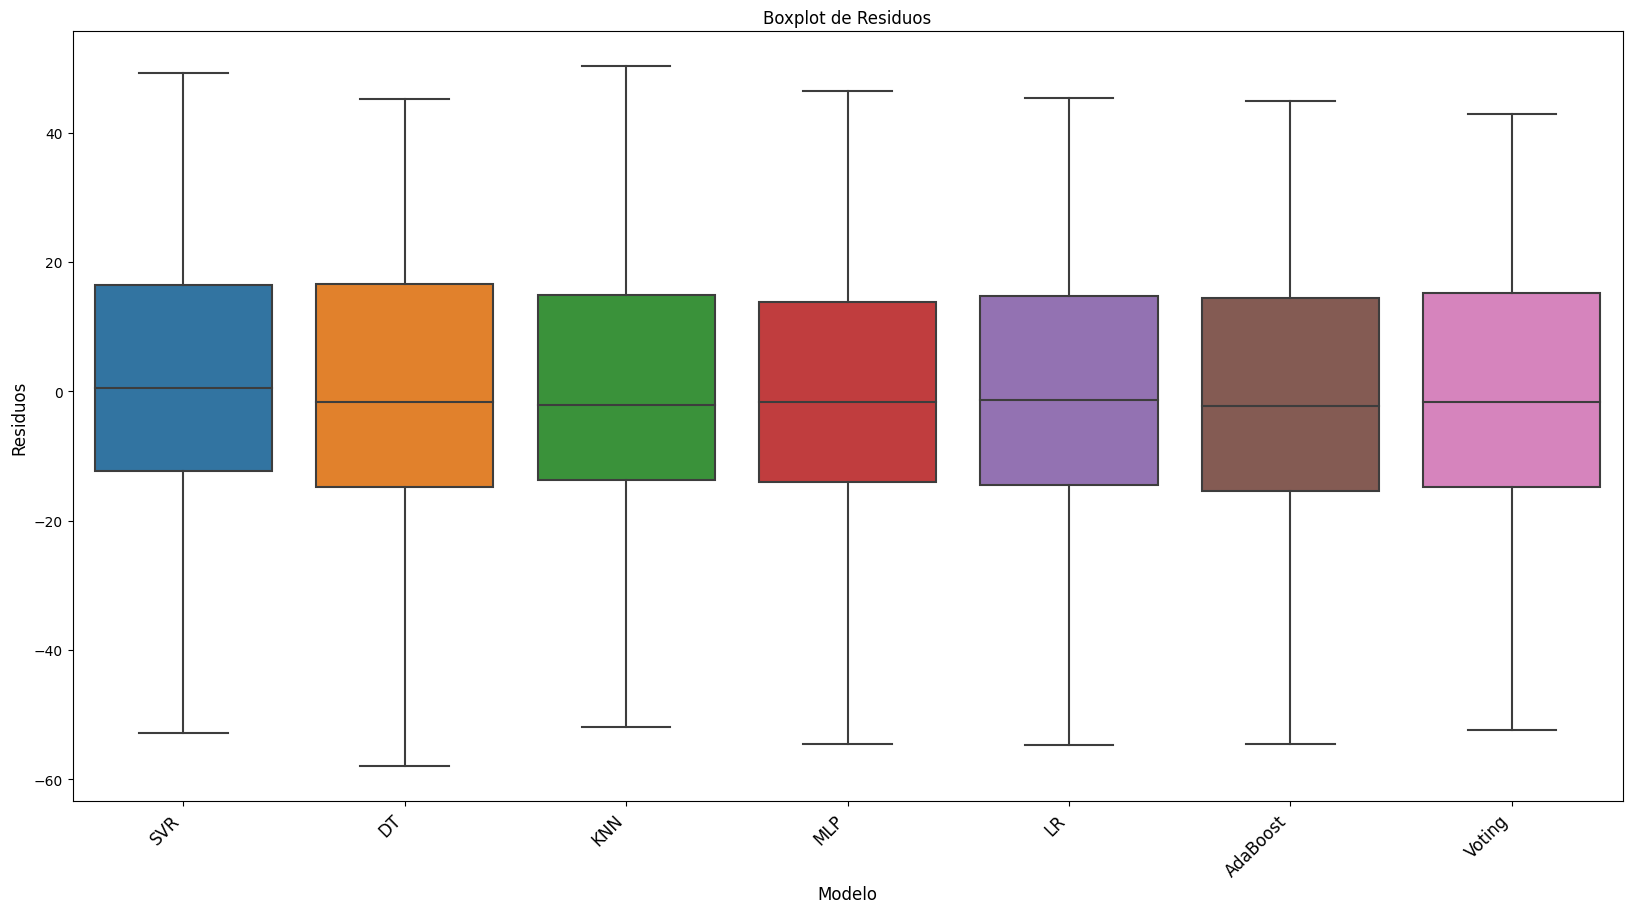

In [142]:
plt.figure(figsize=(20,10))
sns.boxplot(data=SIGNIFICATIVAS["Residuos"])
plt.gca().set_xticklabels(modelos,rotation=45, ha='right')
# cambiar el tamaño de la letra
plt.rc('xtick', labelsize=12)
# cambiar los labels de los ejes
# cambiar tamaño ejes
plt.rc('axes', labelsize=12)

plt.title("Boxplot de Residuos")
plt.xlabel("Modelo")
plt.ylabel("Residuos")
plt.show()

In [143]:
# sacar la mediana y el rango intercuartilico de cada modelo
res = {}
for df in [TODAS,SIGNIFICATIVAS]:
    for i in range(len(df)):
        print(df["Modelo"][i])
        print("Mediana: ", np.median(df["Residuos"][i]))
        print("STD: ",np.std(df["Residuos"][i]))
        print("IQR: ", np.percentile(df["Residuos"][i], 75) - np.percentile(df["Residuos"][i], 25))

SVR()
Mediana:  0.5577314782617186
STD:  18.817086111774582
IQR:  28.899444301777066
DecisionTreeRegressor()
Mediana:  -1.6652329749104595
STD:  19.02301130262964
IQR:  31.400000000000006
KNeighborsRegressor()
Mediana:  -2.1499999999999986
STD:  19.9546814056251
IQR:  28.67999999999999
MLPRegressor()
Mediana:  -1.6856073057392642
STD:  18.668533443965057
IQR:  27.88636397077797
LinearRegression()
Mediana:  -1.4085530952844785
STD:  18.618825103441235
IQR:  29.16761093617646
AdaBoostRegressor()
Mediana:  -2.250235584083068
STD:  18.880400347340235
IQR:  29.906811406995168
VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('knn', KNeighborsRegressor(n_neighbors=10)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.01,
                                               n_estimators=150))])
Mediana:  -1.5927723911010716
STD:  18.811803443705763
IQR:  29.965601065072548


In [144]:
# normalidad de los residuos
from scipy.stats import shapiro
for df in [TODAS,SIGNIFICATIVAS]:
    for i in range(len(df)):
        print(df["Modelo"][i])
        print(shapiro(df["Residuos"][i]))

SVR()
ShapiroResult(statistic=0.9897850751876831, pvalue=0.16619493067264557)
DecisionTreeRegressor()
ShapiroResult(statistic=0.9877201914787292, pvalue=0.08182142674922943)
KNeighborsRegressor()
ShapiroResult(statistic=0.9941593408584595, pvalue=0.6243285536766052)
MLPRegressor()
ShapiroResult(statistic=0.9888729453086853, pvalue=0.12178555876016617)
LinearRegression()
ShapiroResult(statistic=0.9879350662231445, pvalue=0.08813946694135666)
AdaBoostRegressor()
ShapiroResult(statistic=0.9904931783676147, pvalue=0.21069248020648956)
VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('knn', KNeighborsRegressor(n_neighbors=10)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.01,
                                               n_estimators=150))])
ShapiroResult(statistic=0.9899150729179382, pvalue=0.173646941781044)


In [145]:
# homogeneidad de varianzas para todos los modelos
from scipy.stats import levene

levene(df["Residuos"][0], df["Residuos"][1], df["Residuos"][2], df["Residuos"][3], df["Residuos"][4], df["Residuos"][5], df["Residuos"][6])


LeveneResult(statistic=0.18792643747708762, pvalue=0.9802590311043611)

In [146]:
# realizar un test de anova para ver si hay diferencias significativas entre los modelos
# sacar los residuos de cada modelo
residuos = []
for i in range(len(SIGNIFICATIVAS)):
    residuos.append(SIGNIFICATIVAS["Residuos"][i])

# test de anova
f_oneway(*residuos)

F_onewayResult(statistic=0.3879991345434139, pvalue=0.8870518131329391)

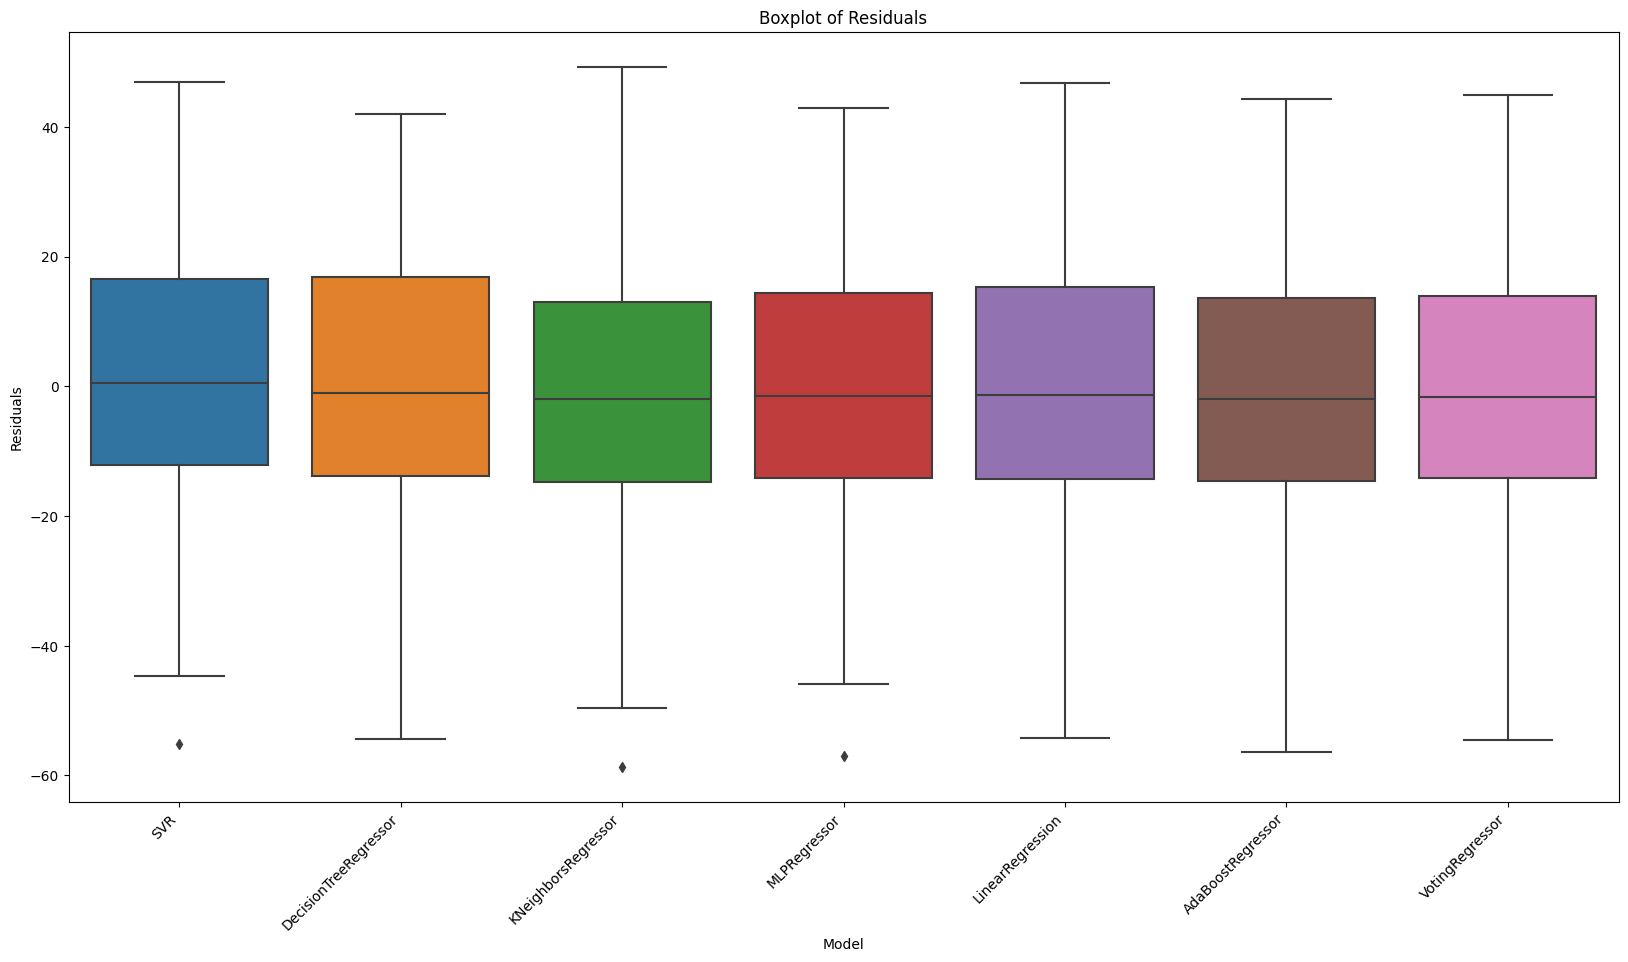

In [59]:
# boxplot de los residuos de cada modelo
plt.figure(figsize=(20,10))
sns.boxplot(data=SIGNIFICATIVAS["Residuos"])
plt.gca().set_xticklabels(modelos, rotation=45, ha='right')
plt.title("Boxplot of Residuals")
plt.xlabel("Model")
plt.ylabel("Residuals")
plt.show()

In [133]:
# examinar el valor atipico de cada modelo
for i in range(len(SIGNIFICATIVAS)):
    print(modelos[i])
    print(sorted(SIGNIFICATIVAS["Residuos"][i]))
    print()

SVR
[-55.23935328495119, -44.62125443152644, -35.307531307523, -34.877853363126995, -34.133956088861964, -30.950247807335646, -30.00546558951504, -29.24788351786284, -28.383955495774497, -27.483535641306055, -27.009635371514047, -26.16917848722019, -25.67378831041217, -25.665805218787938, -25.45190448905265, -25.298659792171122, -24.932296762614378, -23.646904712009913, -22.405701905413935, -22.326709951720126, -22.155292495515802, -22.129127243389718, -22.04569136492718, -21.610795383518415, -19.260122353382066, -19.25870168151559, -18.27500499215359, -18.185613484312327, -18.145084843983533, -18.140314928978768, -18.07936541812073, -18.03205563475978, -17.978634472701017, -17.926968122893264, -17.886430834328927, -17.709405063584796, -17.10659922148654, -16.326032457951975, -15.40404685000378, -15.365891244284356, -15.277185460881014, -15.0035961034379, -14.585480416309942, -14.098418985713387, -14.04448778986729, -13.797718539922364, -12.80203764493492, -12.751371119829052, -12.7443

In [134]:
# sacar la fila del valor atipico de cada modelo
for i in range(len(SIGNIFICATIVAS)):
    print(modelos[i])
    print(SIGNIFICATIVAS["Residuos"][i].index(max(SIGNIFICATIVAS["Residuos"][i])))
    print()

SVR
154

DecisionTreeRegressor
8

KNeighborsRegressor
154

MLPRegressor
154

LinearRegression
154

AdaBoostRegressor
18

VotingRegressor
154



In [135]:
# analizar la fila 154
df_final.iloc[154]

BETABLOQUEANTES                   0.000000
ASPIRINA                          1.000000
OTROS_ANTIAGREGANTES              0.000000
OTROS_ANTIARRITMICOS              0.000000
IMC                               0.331429
N_PASTILLAS_D_INICIO              0.769231
AMIODARONA                        0.000000
F_INTERACCIONAN_SINTROM           3.000000
TRT                              20.000000
SEXO                              1.000000
DISLIPEMIA                        1.000000
INSUFICIENCIA_RENAL               0.000000
ENFERMEDAD_PULMONAR               0.000000
APNEA_DEL_SUENO                   0.000000
ADE                               0.947330
NEUTROFILOS                       0.364326
LINFOCITOS                        0.335401
MONOCITOS                         0.620607
HEMOGLOBINA                       0.185567
PLAQUETAS                         0.692007
HTA                               0.000000
DM                                1.000000
ARTERIOPATIA_PERIFERICA           0.000000
INSUFICIENC